# Compare ClimateNet results across resolutions of input data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime
import pandas as pd
import zarr

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(15) # 25 (at least) for processing 3hrly data
#cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.99:45783,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Compare MERRA AR masks across resolution

### Half degree original ARTMIP masks

In [5]:
merra_cnet_path = '/glade/campaign/collections/gdex/data/d651012/catalogues/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path_t2 = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

#merra_files = 'MERRA2.ar_tag.ClimateNet_DL_model.3hr.20000101-20001231.nc' # year 2000 test
merra_files = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)

In [5]:
merra_cnet_path+merra_files

'/glade/campaign/collections/gdex/data/d651012/catalogues/ClimateNet_DL/*.20[00-15]*'

In [6]:
#merra_cnet = xr.open_dataset(merra_cnet_path+merra_files, chunks='auto')
merra_cnet = xr.open_mfdataset(merra_cnet_path+merra_files, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
#merra_cnet

In [7]:
merra_halfdeg_ar = merra_cnet.ar_binary_tag.sel(time=slice("2000","2015"))
merra_halfdeg_ar

<xarray.DataArray 'ar_binary_tag' (time: 46752, lat: 361, lon: 576)> Size: 10GB
dask.array<getitem, shape=(46752, 361, 576), dtype=int8, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 2kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [8]:
npercentARs_merra_halfdeg = 100*(merra_halfdeg_ar.sum(dim='time'))/len(merra_halfdeg_ar.time)
npercentARs_merra_halfdeg

<xarray.DataArray 'ar_binary_tag' (lat: 361, lon: 576)> Size: 2MB
dask.array<truediv, shape=(361, 576), dtype=float64, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 2kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

In [9]:
npercentARs_merra_halfdeg = npercentARs_merra_halfdeg.persist()

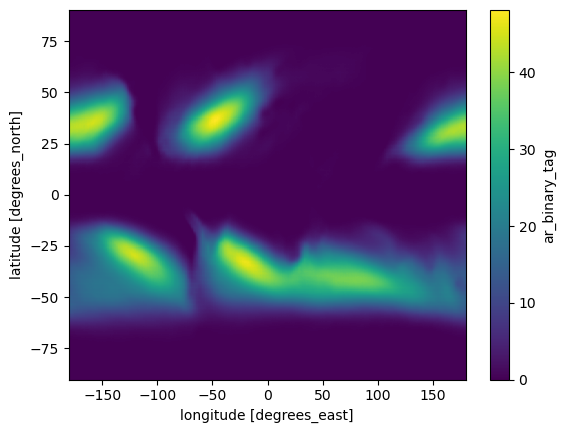

In [45]:
npercentARs_merra_halfdeg.plot();

In [10]:
npercentARs_merra_halfdeg.max().values

array(48.14125599)

### Regridded quarter degree input TMQ

In [4]:
merra_regrid_path = '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/'

In [5]:
#merra_yrs = [str(i) for i in range(2000,2016)]
merra_yrs = [str(i) for i in range(2000,2015)] # 15-year climatology
merra_folders = [y+"/masks_TMQ/" for y in merra_yrs] # pre-trained model using TMQ only

In [6]:
merra_regrid_file = 'class_masks.nc' # can't use wildcard for this to work?
merra_regrid_paths = [merra_regrid_path+merra_folders[i]+merra_regrid_file for i,f in enumerate(merra_folders)]
merra_regrid_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2000/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2001/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2002/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2003/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2004/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2005/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2006/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2007/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2008/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2009/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2010/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2011/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/2012/

In [7]:
%%time
merra_cnet_regrid = xr.open_mfdataset(merra_regrid_paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True)
#merra_cnet_regrid

CPU times: user 1.6 s, sys: 80 ms, total: 1.68 s
Wall time: 15.6 s


In [8]:
merra_quartdeg_ar = merra_cnet_regrid.masks
#merra_quartdeg_ar

In [9]:
npercentARs_merra_quartdeg = 100*((merra_quartdeg_ar.clip(min=1)-1).sum(dim='time'))/len(merra_quartdeg_ar.time)
#npercentARs_merra_quartdeg

In [10]:
npercentARs_merra_quartdeg = npercentARs_merra_quartdeg.persist()

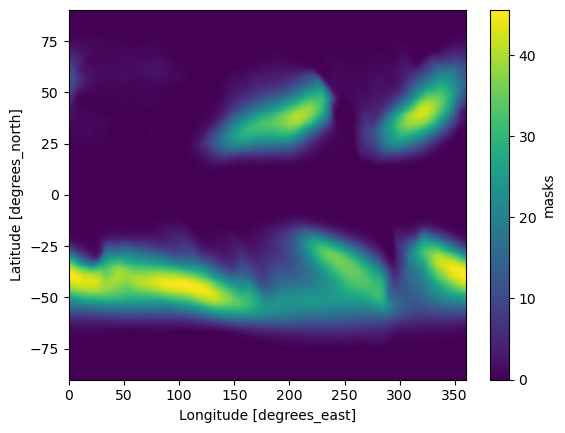

In [20]:
npercentARs_merra_quartdeg.plot();

In [11]:
npercentARs_merra_quartdeg.max().values

array(45.49415952)

### Compare MERRA from ARTMIP vs. regridded TMQ only

/glade/derecho/scratch/kdagon/tmp/ipykernel_69913/2255082733.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 10)


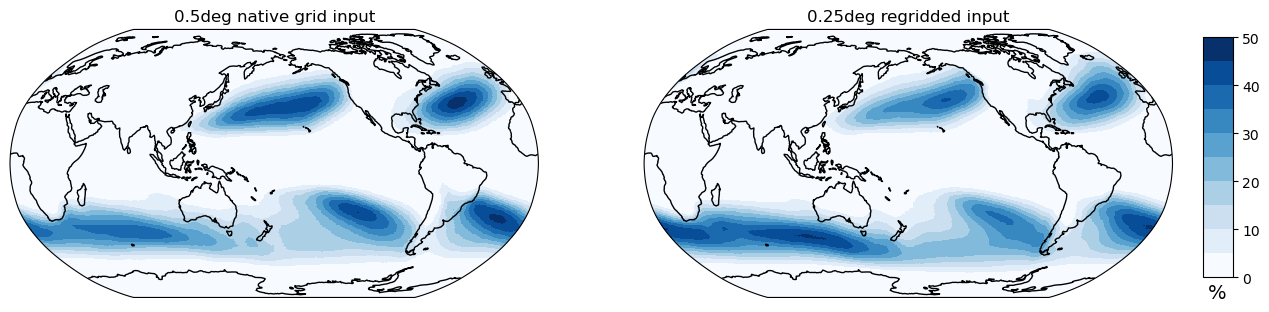

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 1 row, 2 columns

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# 0.5deg
lat = npercentARs_merra_halfdeg.lat
lon = npercentARs_merra_halfdeg.lon
pc = axes[0].pcolormesh(lon, lat, npercentARs_merra_halfdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('0.5deg native grid input')

# 0.25deg
lat = npercentARs_merra_quartdeg.lat
lon = npercentARs_merra_quartdeg.lon
pc = axes[1].pcolormesh(lon, lat, npercentARs_merra_quartdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('0.25deg regridded input')

# add colorbar
cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_xlabel('%', fontsize=14);

#### Regrid for difference plot

In [19]:
%%time
regridder = xe.Regridder(npercentARs_merra_quartdeg, npercentARs_merra_halfdeg, "bilinear", periodic=True)
regridder

CPU times: user 13.8 s, sys: 543 ms, total: 14.3 s
Wall time: 13.6 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1152_361x576_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1152) 
Output grid shape:          (361, 576) 
Periodic in longitude?      True

In [20]:
%%time
npercentARs_merra_up = regridder(npercentARs_merra_quartdeg, keep_attrs=True)
npercentARs_merra_up

CPU times: user 2.11 s, sys: 175 ms, total: 2.29 s
Wall time: 4.28 s


<xarray.DataArray 'masks' (lat: 361, lon: 576)> Size: 2MB
dask.array<sum-aggregate, shape=(361, 576), dtype=float64, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 2kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    regrid_method:  bilinear

In [21]:
npercentARs_merra_up = npercentARs_merra_up.persist()

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 19.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
npercentARs_merra_up.max().values

array(45.51915768)

In [24]:
npercentARs_merra_griddiff = npercentARs_merra_up - npercentARs_merra_halfdeg

In [25]:
print(npercentARs_merra_griddiff.max().values, npercentARs_merra_griddiff.min().values)

18.546726502886386 -12.15749125709592


/glade/derecho/scratch/kdagon/tmp/ipykernel_41966/3510871359.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 10)
/glade/derecho/scratch/kdagon/tmp/ipykernel_41966/3510871359.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


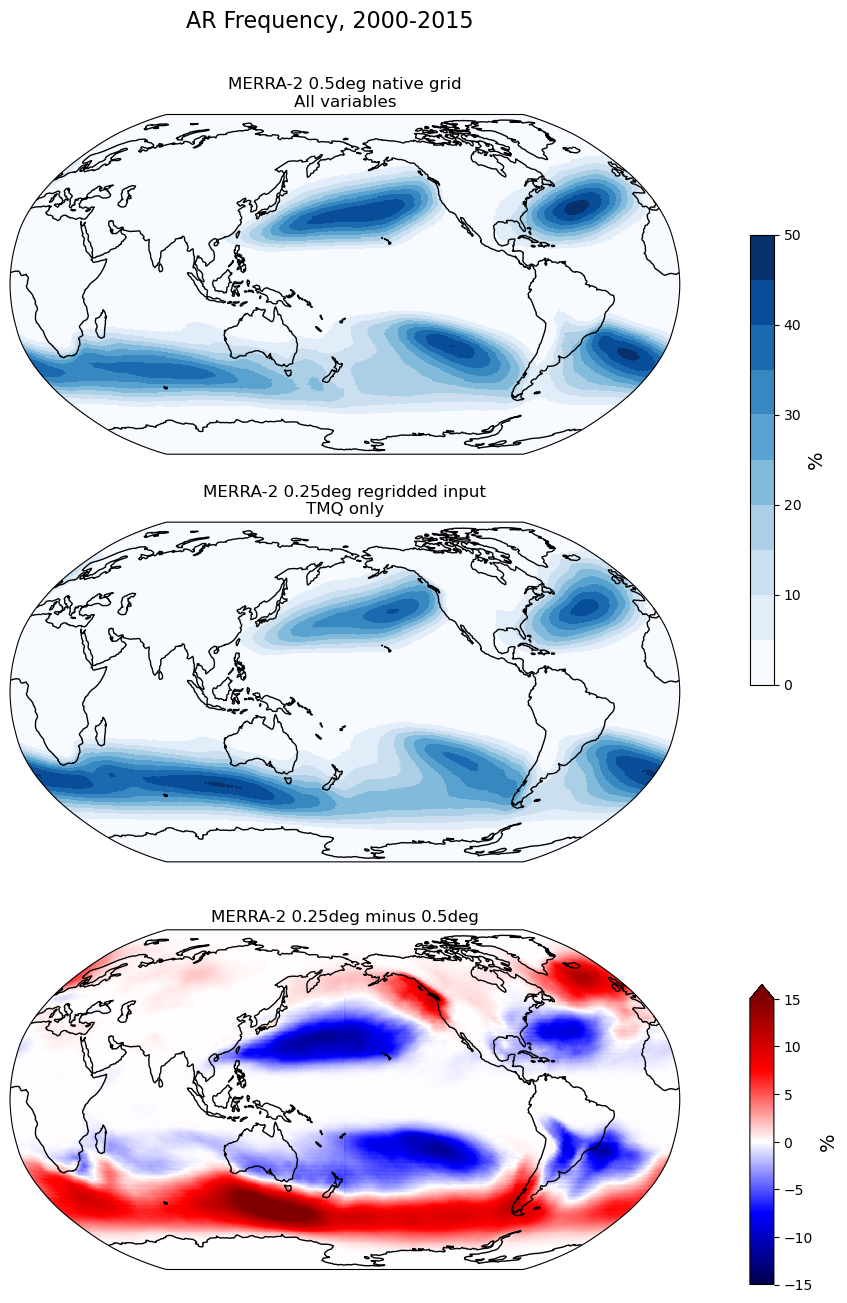

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50 

lat = npercentARs_merra_halfdeg.lat
lon = npercentARs_merra_halfdeg.lon

# 0.5deg native
pc = axes[0].pcolormesh(lon, lat, npercentARs_merra_halfdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('MERRA-2 0.5deg native grid\nAll variables')

# 0.25deg downscaled
lat = npercentARs_merra_quartdeg.lat
lon = npercentARs_merra_quartdeg.lon
pc = axes[1].pcolormesh(lon, lat, npercentARs_merra_quartdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('MERRA-2 0.25deg regridded input\nTMQ only')

# add colorbar
cbar_ax = fig.add_axes([0.85, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
vmin=-15
vmax=15

lat = npercentARs_merra_griddiff.lat
lon = npercentARs_merra_griddiff.lon
pc = axes[2].pcolormesh(lon, lat, npercentARs_merra_griddiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('MERRA-2 0.25deg minus 0.5deg')

cbar_ax = fig.add_axes([0.85, 0.1, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='max')
cbar.ax.set_ylabel('%', fontsize=14)

# add suptitle
fig.suptitle('AR Frequency, 2000-2015', fontsize=16, y=0.95)

#plt.savefig('../figures/toSCP/npercentARs_MERRA_griddiff.png', bbox_inches='tight')

### Original resolution half degree input TMQ
This would be trying to replicate what ARTMIP has, but for TMQ only\
Assuming CGNet did not regrid for ARTMIP, which is unclear

In [12]:
cesm_cnet_filepath = '/glade/campaign/cgd/ccr/kdagon/cgnet/'

In [13]:
merra_orig_path = cesm_cnet_filepath+'MERRA-2/orig_res/'
#merra_orig_path

In [14]:
#merra_yrs = [str(i) for i in range(2000,2016)]
merra_yrs = [str(i) for i in range(2000,2015)] # 15-year climatology
merra_orig_folders = [y+"/masks_TMQ/" for y in merra_yrs] # MERRA TMQ only at original resolution
#merra_orig_folders

In [15]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
merra_orig_paths = [merra_orig_path+merra_orig_folders[i]+cnet_file for i,f in enumerate(merra_orig_folders)]
merra_orig_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2000/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2001/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2002/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2003/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2004/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2005/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2006/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2007/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2008/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2009/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/orig_res/2010/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon

In [16]:
%%time
merra_cnet_TMQ = xr.open_mfdataset(merra_orig_paths, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
#merra_cnet_TMQ

CPU times: user 66 ms, sys: 4.05 ms, total: 70 ms
Wall time: 154 ms


In [17]:
npercentARs_merra_orig = 100*(merra_cnet_TMQ.masks.sum(dim='time'))/len(merra_cnet_TMQ.time)
#npercentARs_merra_orig

In [18]:
npercentARs_merra_orig = npercentARs_merra_orig.persist()

In [19]:
npercentARs_merra_orig.max().values

array(19.42416499)

/glade/derecho/scratch/kdagon/tmp/ipykernel_58338/747361074.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 8)


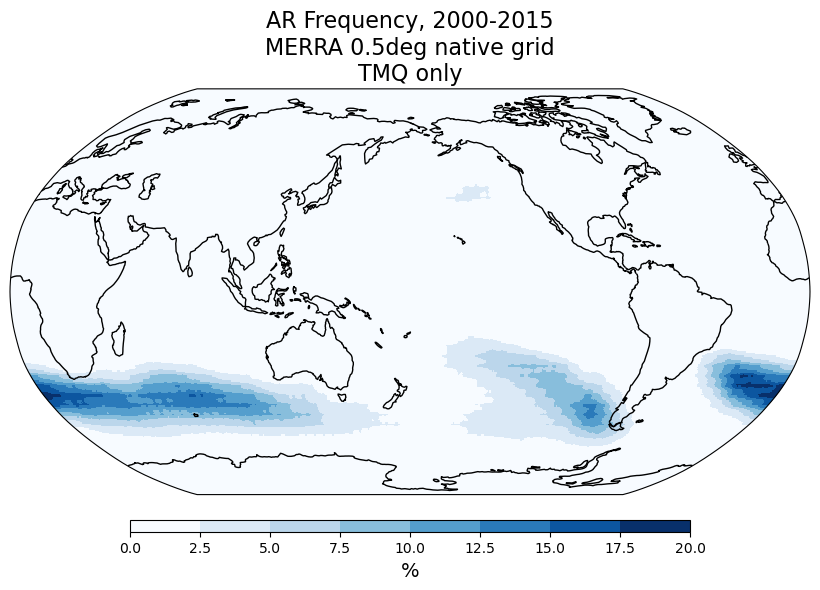

In [15]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

#cmap=plt.cm.get_cmap('Blues', 10)
#vmax=50 # to match other plots

cmap=plt.cm.get_cmap('Blues', 8)
vmax=20

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs_merra_orig.lat
lon = npercentARs_merra_orig.lon
pc = ax.pcolormesh(lon, lat, npercentARs_merra_orig, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('AR Frequency, 2000-2015\nMERRA 0.5deg native grid\nTMQ only', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_MERRA2_0.5deg_TMQ_2000-2015.png', bbox_inches='tight') # before longitudes were shifted
#plt.savefig('../figures/toSCP/npercentARs_MERRA2_0.5deg_TMQ_lons_2000-2015.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_MERRA2_0.5deg_TMQ_lons_scaled_2000-2015.png', bbox_inches='tight')

### Compare MERRA TMQ-only across resolutions

#### Regrid for difference plot

In [20]:
%%time
regridder = xe.Regridder(npercentARs_merra_quartdeg, npercentARs_merra_orig, "bilinear", periodic=True)
regridder

CPU times: user 12.9 s, sys: 547 ms, total: 13.4 s
Wall time: 12.5 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1152_361x576_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1152) 
Output grid shape:          (361, 576) 
Periodic in longitude?      True

In [21]:
%%time
npercentARs_merra_up = regridder(npercentARs_merra_quartdeg, keep_attrs=True)
npercentARs_merra_up

CPU times: user 1.75 s, sys: 198 ms, total: 1.94 s
Wall time: 1.95 s


<xarray.DataArray 'masks' (lat: 361, lon: 576)> Size: 2MB
dask.array<sum-aggregate, shape=(361, 576), dtype=float64, chunksize=(361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB 0.625 1.25 1.875 2.5 ... 358.1 358.8 359.4 360.0
Attributes:
    regrid_method:  bilinear

In [22]:
npercentARs_merra_up = npercentARs_merra_up.persist()

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 19.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
npercentARs_merra_up.max().values

array(45.43335873)

In [24]:
npercentARs_merra_griddiff = npercentARs_merra_up - npercentARs_merra_orig

In [25]:
print(npercentARs_merra_griddiff.max().values, npercentARs_merra_griddiff.min().values)

41.86851923505496 -1.2181739365543538


/glade/derecho/scratch/kdagon/tmp/ipykernel_4662/163185350.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 10)
/glade/derecho/scratch/kdagon/tmp/ipykernel_4662/163185350.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


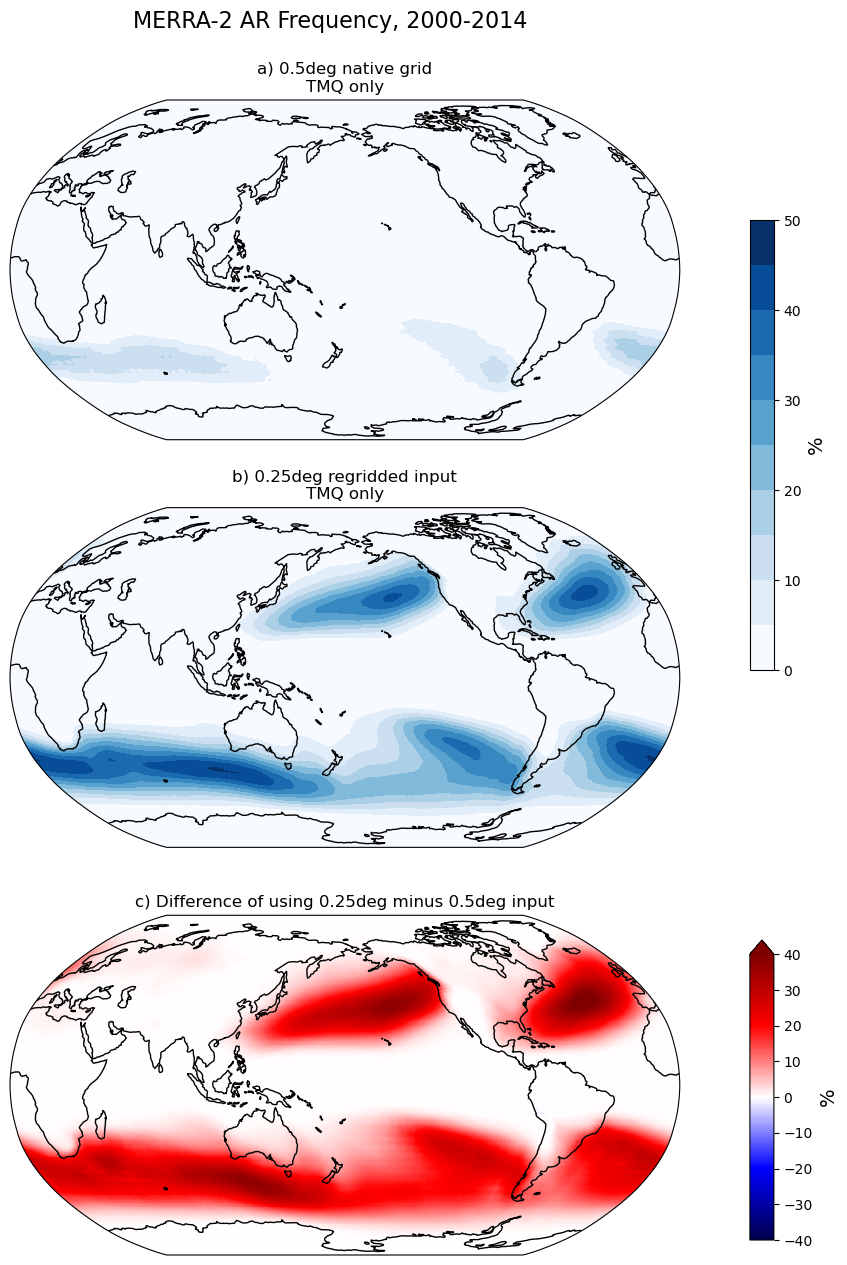

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50 

lat = npercentARs_merra_orig.lat
lon = npercentARs_merra_orig.lon

# 0.5deg native
pc = axes[0].pcolormesh(lon, lat, npercentARs_merra_orig, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('a) 0.5deg native grid\nTMQ only')

# 0.25deg downscaled
lat = npercentARs_merra_quartdeg.lat
lon = npercentARs_merra_quartdeg.lon
pc = axes[1].pcolormesh(lon, lat, npercentARs_merra_quartdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('b) 0.25deg regridded input\nTMQ only')

# add colorbar
cbar_ax = fig.add_axes([0.85, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
vmin=-40
vmax=40

lat = npercentARs_merra_griddiff.lat
lon = npercentARs_merra_griddiff.lon
pc = axes[2].pcolormesh(lon, lat, npercentARs_merra_griddiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('c) Difference of using 0.25deg minus 0.5deg input')

cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='max')
cbar.ax.set_ylabel('%', fontsize=14)

# add suptitle
fig.suptitle('MERRA-2 AR Frequency, 2000-2014', fontsize=16, y=0.94)

#plt.savefig('../figures/toSCP/npercentARs_MERRA_TMQ_griddiff.png', bbox_inches='tight')

## Compare with CESM

In [26]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

In [27]:
hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
#hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std in config file
#hist_folders = ["B20TRC5CN/"+y+"/masks_histrcp26/" for y in hist_yrs] # unweighted means/std from CESM 2000-2015 in config file
#hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ_V850/" for y in hist_yrs] # pre-trained model using TMQ and V850 only
hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ/" for y in hist_yrs] # pre-trained model using TMQ only

#rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp26_yrs = [str(i) for i in range(2006,2015)] # 15-yr climatology
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # updated data processing (3hrly PSL), unweighted means/std in config file
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_histrcp26/" for y in rcp26_yrs] # unweighted means/std from CESM 2000-2015 in config file
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ_V850/" for y in rcp26_yrs] # pre-trained model using TMQ and V850 only
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ/" for y in rcp26_yrs] # pre-trained model using TMQ only

In [28]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)] + [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/masks_TMQ/class_masks.nc',
 '/glade/campaign/cgd/

In [29]:
%%time
cesm_cnet = xr.open_mfdataset(paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True)
#cesm_cnet

CPU times: user 164 ms, sys: 7.53 ms, total: 171 ms
Wall time: 471 ms


In [30]:
cesm_ar = cesm_cnet.masks
#cesm_ar

In [31]:
npercentARs_cesm = 100*((cesm_ar.clip(min=1)-1).sum(dim='time'))/len(cesm_ar.time)
#npercentARs_cesm

In [32]:
npercentARs_cesm = npercentARs_cesm.persist()

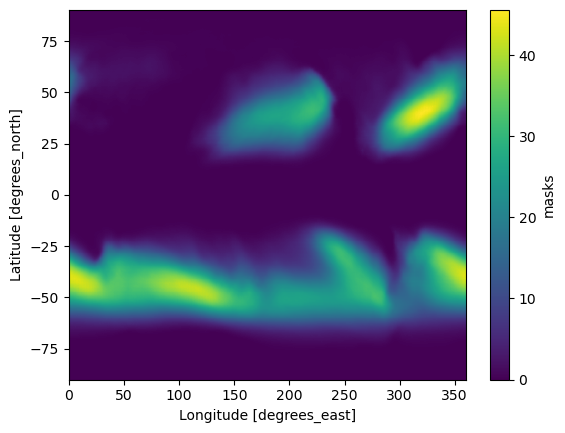

In [33]:
npercentARs_cesm.plot();

In [33]:
npercentARs_cesm.max().values

array(45.56392694)

/glade/derecho/scratch/kdagon/tmp/ipykernel_69913/2584019653.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 10)


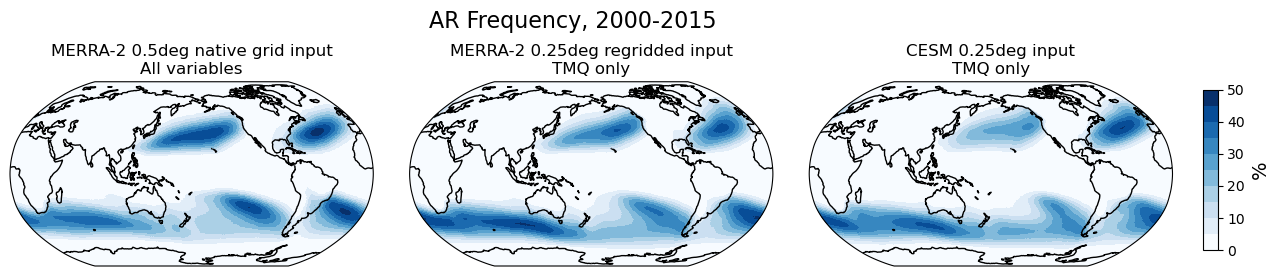

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 1 row, 3 columns

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# 0.5deg MERRA
lat = npercentARs_merra_halfdeg.lat
lon = npercentARs_merra_halfdeg.lon
pc = axes[0].pcolormesh(lon, lat, npercentARs_merra_halfdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('MERRA-2 0.5deg native grid input\nAll variables')

# 0.25deg MERRA
lat = npercentARs_merra_quartdeg.lat
lon = npercentARs_merra_quartdeg.lon
pc = axes[1].pcolormesh(lon, lat, npercentARs_merra_quartdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('MERRA-2 0.25deg regridded input\nTMQ only')

# 0.25deg CESM
lat = npercentARs_cesm.lat
lon = npercentARs_cesm.lon
pc = axes[2].pcolormesh(lon, lat, npercentARs_cesm, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('CESM 0.25deg input\nTMQ only')

# add colorbar
cbar_ax = fig.add_axes([0.92, 0.4, 0.01, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# suptitle
#fig.suptitle('AR Frequency, Year 2000', fontsize=16, y=0.7)
fig.suptitle('AR Frequency, 2000-2015', fontsize=16, y=0.7)

plt.subplots_adjust(wspace=0.1, hspace=0);

#plt.savefig('../figures/toSCP/npercentARs_MERRA_CESM_2000_grids.png', bbox_inches='tight')
plt.savefig('../figures/toSCP/npercentARs_MERRA_CESM_grids.png', bbox_inches='tight')

### CESM/MERRA diffs

In [34]:
diffs = npercentARs_merra_quartdeg - npercentARs_cesm
print(diffs.min().values, diffs.max().values)

-8.833201655803268 17.14047200560713


/glade/derecho/scratch/kdagon/tmp/ipykernel_69913/1306901090.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 10)
/glade/derecho/scratch/kdagon/tmp/ipykernel_69913/1306901090.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


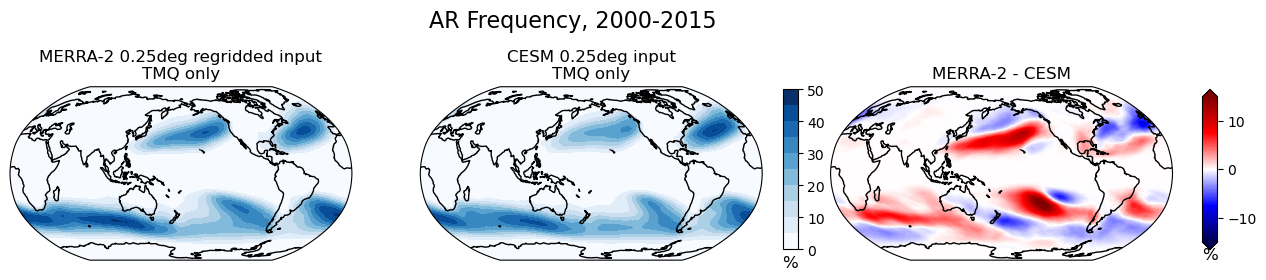

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 1 row, 3 columns

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# 0.25deg MERRA
lat = npercentARs_merra_quartdeg.lat
lon = npercentARs_merra_quartdeg.lon
pc = axes[0].pcolormesh(lon, lat, npercentARs_merra_quartdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('MERRA-2 0.25deg regridded input\nTMQ only')

# 0.25deg CESM
lat = npercentARs_cesm.lat
lon = npercentARs_cesm.lon
pc = axes[1].pcolormesh(lon, lat, npercentARs_cesm, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('CESM 0.25deg input\nTMQ only')

# add colorbar
cbar_ax = fig.add_axes([0.64, 0.4, 0.01, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_xlabel('%', fontsize=12);

cmap=plt.cm.get_cmap('seismic')
vmin=-15
vmax=15

# Diff
lat = diffs.lat
lon = diffs.lon
pc = axes[2].pcolormesh(lon, lat, diffs, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('MERRA-2 - CESM')

# add colorbar
cbar_ax = fig.add_axes([0.92, 0.4, 0.01, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='both')
cbar.ax.set_xlabel('%', fontsize=12)

# suptitle
#fig.suptitle('AR Frequency, Year 2000', fontsize=16, y=0.7);
fig.suptitle('AR Frequency, 2000-2015', fontsize=16, y=0.7);

plt.subplots_adjust(wspace=0.2, hspace=0);

#plt.savefig('../figures/toSCP/npercentARs_MERRA_CESM_2000_diffs.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_MERRA_CESM_diffs.png', bbox_inches='tight')

Vertical panel plot

/glade/derecho/scratch/kdagon/tmp/ipykernel_41966/1580392624.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 10)
/glade/derecho/scratch/kdagon/tmp/ipykernel_41966/1580392624.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


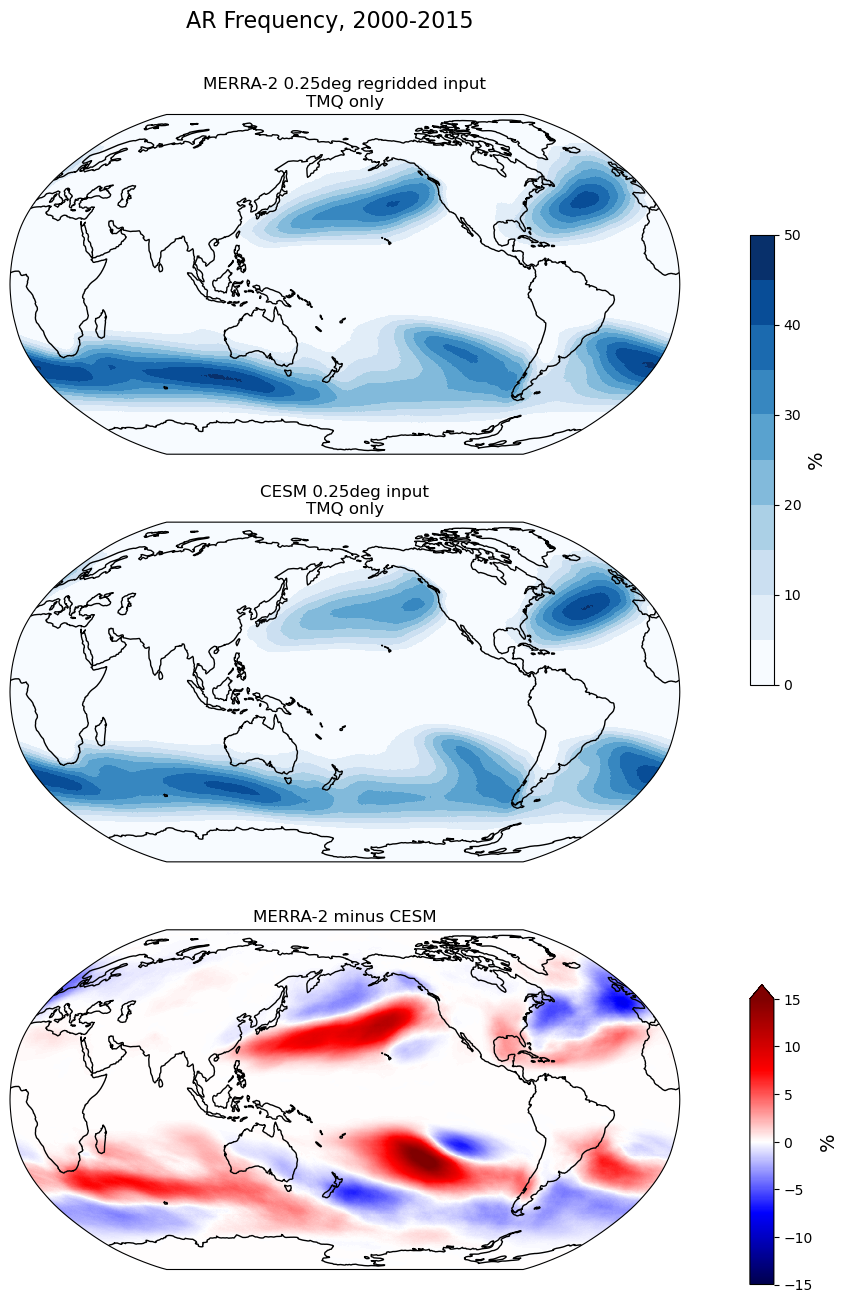

In [37]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})  # 3 rows, 1 column

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50 

lat = npercentARs_merra_quartdeg.lat
lon = npercentARs_merra_quartdeg.lon

# 0.25deg merra
pc = axes[0].pcolormesh(lon, lat, npercentARs_merra_quartdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('MERRA-2 0.25deg regridded input\nTMQ only')

# 0.25deg cesm
lat = npercentARs_cesm.lat
lon = npercentARs_cesm.lon
pc = axes[1].pcolormesh(lon, lat, npercentARs_cesm, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('CESM 0.25deg input\nTMQ only')

# add colorbar
cbar_ax = fig.add_axes([0.85, 0.5, 0.02, 0.3]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=14)

# diff
cmap=plt.cm.get_cmap('seismic')
vmin=-15
vmax=15

lat = diffs.lat
lon = diffs.lon
pc = axes[2].pcolormesh(lon, lat, diffs, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('MERRA-2 minus CESM')

cbar_ax = fig.add_axes([0.85, 0.1, 0.02, 0.2]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='max')
cbar.ax.set_ylabel('%', fontsize=14)

# add suptitle
fig.suptitle('AR Frequency, 2000-2015', fontsize=16, y=0.95)

#plt.savefig('../figures/toSCP/npercentARs_MERRA_CESM_diffs_vertical.png', bbox_inches='tight')

## Compare CESM and MERRA across resolutions (TMQ only)

In [38]:
print(npercentARs_merra_orig.max().values, npercentARs_merra_quartdeg.max().values, npercentARs_cesm.max().values)

19.424164993611974 45.494159518160245 45.56392694063927


In [35]:
# MERRA 0.25 minus 0.5, TMQ-only
print(npercentARs_merra_griddiff.max().values, npercentARs_merra_griddiff.min().values)

41.86851923505496 -1.2181739365543538


In [34]:
# MERRA minus CESM, TMQ-only 0.25deg
diffs = npercentARs_merra_quartdeg - npercentARs_cesm
print(diffs.min().values, diffs.max().values)

-8.833201655803268 17.14047200560713


/glade/derecho/scratch/kdagon/tmp/ipykernel_4889/320633235.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 10)
/glade/derecho/scratch/kdagon/tmp/ipykernel_4889/320633235.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


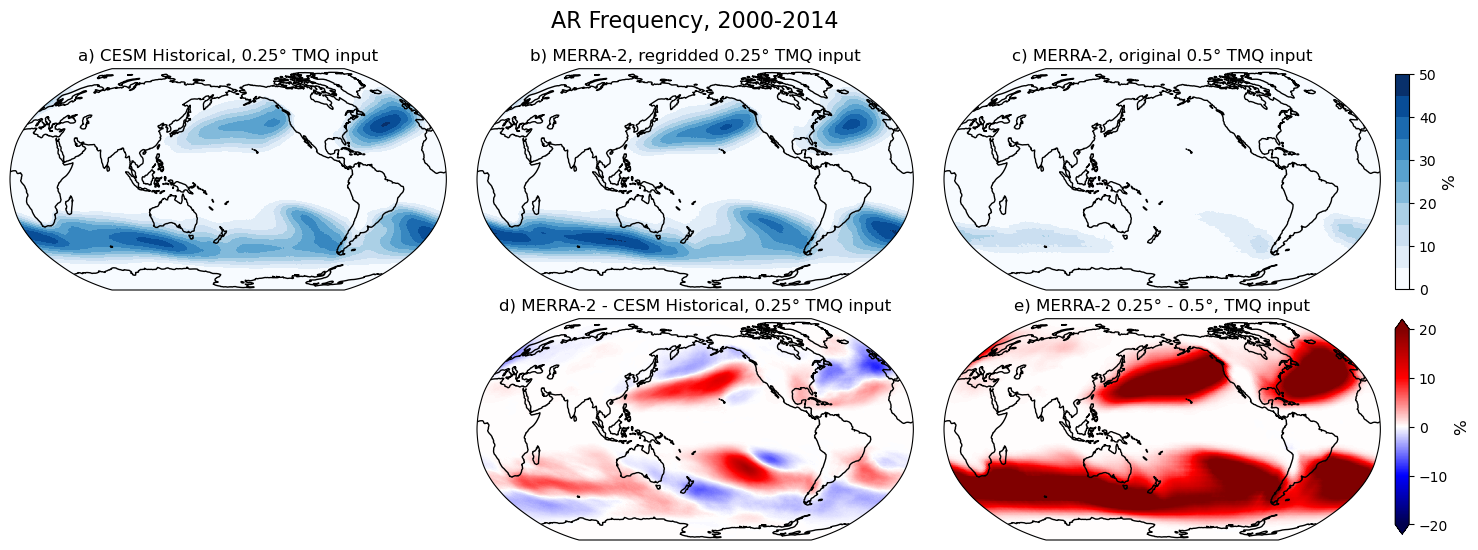

In [42]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper middle', 'upper right'],
                               ['X', 'lower middle', 'lower right']], empty_sentinel='X',
                              figsize=(14,5), layout="constrained",
                              subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

# colormap/scale for absolute plots
cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

# CESM Historical, TMQ only
lat = npercentARs_cesm.lat
lon = npercentARs_cesm.lon
pc = ax['upper left'].pcolormesh(lon, lat, npercentARs_cesm, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper left'].coastlines()
ax['upper left'].set_title('a) CESM Historical, 0.25\u00b0 TMQ input', fontsize=12)

# MERRA-2 Tier 1 regridded 0.25deg input, TMQ only
lat = npercentARs_merra_quartdeg.lat
lon = npercentARs_merra_quartdeg.lon
pc = ax['upper middle'].pcolormesh(lon, lat, npercentARs_merra_quartdeg, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper middle'].coastlines()
ax['upper middle'].set_title('b) MERRA-2, regridded 0.25\u00b0 TMQ input', fontsize=12)

# MERRA-2 Tier 1 original 0.5deg input, TMQ only
lat = npercentARs_merra_orig.lat
lon = npercentARs_merra_orig.lon
pc = ax['upper right'].pcolormesh(lon, lat, npercentARs_merra_orig, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
ax['upper right'].coastlines()
ax['upper right'].set_title('c) MERRA-2, original 0.5\u00b0 TMQ input', fontsize=12)

# add colorbar for absolute plots
cbar_ax = fig.add_axes([1.0, 0.51, 0.01, 0.43]) #(left, bottom, width, height)
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.ax.set_ylabel('%', fontsize=12)

# colormap/scale for diff plots
cmap=plt.cm.get_cmap('seismic')
vmin=-20
vmax=20

# MERRA minus CESM, TMQ-only at 0.25deg
lat = diffs.lat
lon = diffs.lon
pc = ax['lower middle'].pcolormesh(lon, lat, diffs, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower middle'].coastlines()
ax['lower middle'].set_title('d) MERRA-2 - CESM Historical, 0.25\u00b0 TMQ input', fontsize=12)

# MERRA 0.25 minus 0.5, TMQ-only
lat = npercentARs_merra_griddiff.lat
lon = npercentARs_merra_griddiff.lon
pc = ax['lower right'].pcolormesh(lon, lat, npercentARs_merra_griddiff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax['lower right'].coastlines()
ax['lower right'].set_title('e) MERRA-2 0.25\u00b0 - 0.5\u00b0, TMQ input', fontsize=12)

# add colorbar
cbar_ax = fig.add_axes([1.0, 0.02, 0.01, 0.43])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='vertical', extend='both')
cbar.ax.set_ylabel('%', fontsize=12);

# add suptitle
fig.suptitle('AR Frequency, 2000-2014', fontsize=16, y=1.07);

#plt.subplots_adjust(wspace=0.1, hspace=0) # can't use with subplot_mosaic

#plt.savefig('../figures/toSCP/npercentARs_merra_cesm_griddiffs.png', dpi=300, bbox_inches='tight')